# Homework 3
- INFO 4871 / 5871
- Spring 2019
- __Payoj Jain__

# NOTE: LKPy 0.6.0

To do this homework, you will need to upgrade to LKPy version 0.6.0. I generally try to avoid requiring software changes in the middle of the quarter, but in this case, the benefits are (I believe) worth the hassle. Using `conda` to update should be sufficient. If you have trouble with the update not being detected (as I did on my Mac), you may need to use the `pip`+github method described at https://github.com/lenskit/lkpy.

## Objective (all students)
The object of this assignment is to gain familiarity with algorithm evaluation in LKPy. You will do this by implementing a simple hybrid recommender system and evaluating it relative to its components. I have provided the following:
- An outline of the WeightedHybrid class. 
- A useful utility function my_clone in hwk3_util.py
- A simple test case for the WeightedHybrid class
- The definition of two knn algorithms UserUserFallback and ItemItemFallback in Fallbacks.py. These are also hybrids in which Bias algorithm is used to predict if not enough neighbors are found. 

You will first implement the WeightedHybrid. It computes a numerical prediction from its component algorithms and then combines these in a weighted average. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Predictor, Recommender
from lenskit.algorithms.basic import UnratedItemCandidateSelector
from lenskit.metrics.predict import rmse

In [3]:
%load_ext autoreload
%aimport Weighted_Hybrid
%aimport hwk3_util
%autoreload 2

from Weighted_Hybrid import WeightedHybrid
from hwk3_util import my_clone
from Fallbacks import UserUserFallback, ItemItemFallback

## 1. Implement Weighted Hybrid

In [4]:
import unittest
from test_weighted import test_WeightedHybrid

%aimport test_weighted

In [5]:
suite = unittest.TestLoader().loadTestsFromTestCase(test_weighted.test_WeightedHybrid)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_more_components (test_weighted.test_WeightedHybrid) ... ok
test_normalize_weights (test_weighted.test_WeightedHybrid) ... ok
test_predict (test_weighted.test_WeightedHybrid) ... ok

----------------------------------------------------------------------
Ran 3 tests in 2.783s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Evaluation with RMSE

### Load ratings data

In [6]:
ratings = pd.read_csv('ratings.csv', encoding='latin1')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})
ratings = ratings.drop('timestamp', axis=1)
ratings.head()

,user,item,rating
0,12882,1,4.0
1,12882,32,3.5
2,12882,47,5.0
3,12882,50,5.0
4,12882,110,4.5


### Create algorithms
Neighbors = 20, Min neighbors = 5

In [7]:
user = UserUserFallback(20, min_nbrs=5)
item = ItemItemFallback(20, min_nbrs=5)

### Weighted hybrid 
UserUser 0.8 ItemItem 0.2

In [8]:
weighted_hybrid = WeightedHybrid([user, item], [0.8,0.2])

### A helper function for doing the evaluation
Makes repeated calls to `batch.predict` easier to perform.

(Adapted from LKPy "Getting started" documentation.)

In [9]:
def eval_preds(aname, fold, algo, train, test):
    fittable = my_clone(algo)
    fittable.fit(train)
    
    preds = batch.predict(fittable, test)
    preds['Algorithm'] = aname
    preds['Fold'] = fold
    return preds

### Perform 5-fold cross-validation
Note that all the happens here is that predictions are generated. Evaluation is later.

In [10]:
np.random.seed(20190303)

all_preds = []
fold = 0
# HOMEWORK 3 TODO
# Implement 5-fold cross-validation with user-based splitting
# Call eval_preds for each algorithm, each fold
# Results should be appended to all_preds

# for i, tp in enumerate(xf.partition_users(ratings, 5, xf.SampleN(5))):
#     tp.train.to_csv('ml-20m.exp/train-%d.csv' % (i,))
#     tp.train.to_parquet('ml-20m.exp/train-%d.parquet % (i,))
#     tp.test.to_csv('ml-20m.exp/test-%d.csv' % (i,))
#     tp.test.to_parquet('ml-20m.exp/test-%d.parquet % (i,))

algorithm_type = [(user,'UserUser'), (item,'ItemItem'), (weighted_hybrid,'Weighted Hybrid')]

for train, test in xf.partition_users(ratings[['user', 'item', 'rating']],5, xf.SampleFrac(0.2)):
    for algo in algorithm_type:
        all_preds.append(eval_preds(algo[1], fold, algo[0], train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


### Combine all results into one data frame

In [11]:
all_preds = pd.concat(all_preds, ignore_index=True)
all_preds.head()

,user,item,rating,prediction,Algorithm,Fold
0,975,112852,4.0,3.930192,UserUser,0
1,975,4011,4.0,4.083562,UserUser,0
2,975,1732,4.5,4.312282,UserUser,0
3,975,5952,3.5,4.038854,UserUser,0
4,975,91658,3.5,3.986704,UserUser,0


### Compute results
- Create an RMSE for each fold of each algorithm
- Compute the mean and standard deviation of over the folds for each algorithm

No loops. 2-3 or three lines of code. `groupby`, `apply`, and `agg` are your friends. 

In [12]:
rmse_per_fold = all_preds.groupby(['Algorithm','Fold']).apply(lambda df: rmse(df.prediction, df.rating))
means = rmse_per_fold.groupby('Algorithm').mean()
stds = rmse_per_fold.groupby('Algorithm').agg('std')

In [13]:
print("RMSE per fold per Algorithm:\n",rmse_per_fold)
print()
print("Mean of RMSE per fold per Algorithm:\n",means)
print()
print("Standard deviations per fold per Algorithm:\n",stds)

RMSE per fold per Algorithm:
 Algorithm        Fold
ItemItem         0       0.757571
                 1       0.743245
                 2       0.738638
                 3       0.803013
                 4       0.728331
UserUser         0       0.793968
                 1       0.777079
                 2       0.770060
                 3       0.831445
                 4       0.760025
Weighted Hybrid  0       0.779125
                 1       0.762325
                 2       0.756490
                 3       0.818690
                 4       0.745567
dtype: float64

Mean of RMSE per fold per Algorithm:
 Algorithm
ItemItem           0.754159
UserUser           0.786515
Weighted Hybrid    0.772439
dtype: float64

Standard deviations per fold per Algorithm:
 Algorithm
ItemItem           0.029264
UserUser           0.027999
Weighted Hybrid    0.028559
dtype: float64


### Plot the experimental results
Bar plot with error bars. Don't forget to label the y axis.

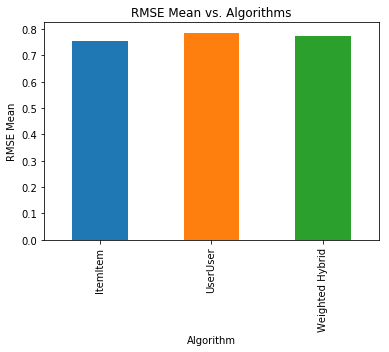

In [14]:
ax = means.plot.bar()
ax.set_ylabel("RMSE Mean")
ax.set_title("RMSE Mean vs. Algorithms")
plt.show()

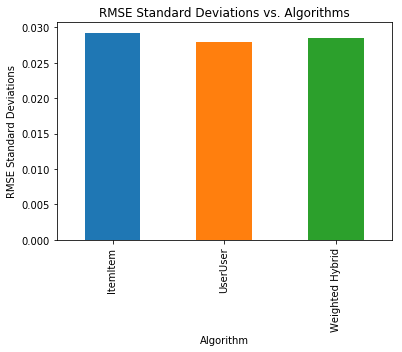

In [15]:
ax = stds.plot.bar()
ax.set_ylabel("RMSE Standard Deviations")
ax.set_title("RMSE Standard Deviations vs. Algorithms")
plt.show()

## Evaluation with recall / precision

### Helper function
Repeated calls to `batch.recommend`. Generate 10 recommendations.

In [16]:
def eval_recs(aname, fold, algo, train, test):
    fittable = my_clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 10)
    # add the algorithm
    recs['Algorithm'] = aname
    recs['Fold'] = fold
    return recs


### Perform 5-fold cross-validation

In [17]:
np.random.seed(20190302)

all_recs = []
test_data = []
fold = 0

    # HOMEWORK 3 TODO
    # Implement 5-fold cross-validation with user-based splitting
    # Call eval_recs for each algorithm, each fold
    # Results should be appended to all_recs
    # Test data should be appended to test_data

algorithm_type = [(user,'UserUser'), (item,'ItemItem'), (weighted_hybrid,'Weighted Hybrid')]

for train, test in xf.partition_users(ratings[['user', 'item', 'rating']],5, xf.SampleFrac(0.2)):
    test_data.append(test)
    for algo in algorithm_type:
        all_recs.append(eval_recs(algo[1], fold, algo[0], train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


### Combine results into one data frame

In [18]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm,Fold
0,296,4.708202,359,1,UserUser,0
1,7361,4.632040,359,2,UserUser,0
2,589,4.626236,359,3,UserUser,0
3,4973,4.620123,359,4,UserUser,0
4,1193,4.590232,359,5,UserUser,0


### Combine test data into a data frame
Needed by the list-oriented evaluation metrics

In [19]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,359,4144,3.0
1,359,3061,4.5
2,359,800,4.0
3,359,8985,4.0
4,359,48043,4.0


### Computing recall and precision

This step is a bit difficult, and requires an understanding of how `RecListAnalysis` works. So, I supplied the first part of the cell. 

- Create the `RecListAnalysis` object
- Compute the list metrics for each user
- Average the users in each fold for each algorithm
- Compute mean and standard deviation for the algorithm over the folds.

In [20]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.precision)
rla.add_metric(topn.recall)

byuser_results = all_recs.groupby(['Algorithm', 'Fold']).apply(lambda df: rla.compute(df, test_data))



### Show data frame with evaluation results

In [21]:
byuser_results.head()

precision    recall
Algorithm Fold user Algorithm Fold                     
ItemItem  0    359  ItemItem  0           0.2  0.011976
               1015 ItemItem  0           0.2  0.035714
               1387 ItemItem  0           0.0  0.000000
               2702 ItemItem  0           0.1  0.013889
               4483 ItemItem  0           0.1  0.012658

In [66]:
precision_mean = byuser_results.groupby('Algorithm')['precision'].mean()
recall_mean = byuser_results.groupby('Algorithm')['recall'].mean()
print("Precision Mean: \n",precision_mean)
print()
print("Recall Mean: \n", recall_mean)

Precision Mean: 
 Algorithm
ItemItem           0.117981
UserUser           0.165777
Weighted Hybrid    0.170534
Name: precision, dtype: float64

Recall Mean: 
 Algorithm
ItemItem           0.023115
UserUser           0.029226
Weighted Hybrid    0.030523
Name: recall, dtype: float64


In [65]:
precision_std = byuser_results.groupby('Algorithm')['precision'].std()
recall_std = byuser_results.groupby('Algorithm')['recall'].std()
print("Precision Standard Deviation: \n",precision_std)
print()
print("Recall Standard deviation: \n", recall_std)

Precision Standard Deviation: 
 Algorithm
ItemItem           0.160180
UserUser           0.182957
Weighted Hybrid    0.188248
Name: precision, dtype: float64

Recall Standard deviation: 
 Algorithm
ItemItem           0.040645
UserUser           0.038085
Weighted Hybrid    0.039273
Name: recall, dtype: float64


### Bar plot of precision
Similar to above with error bars.

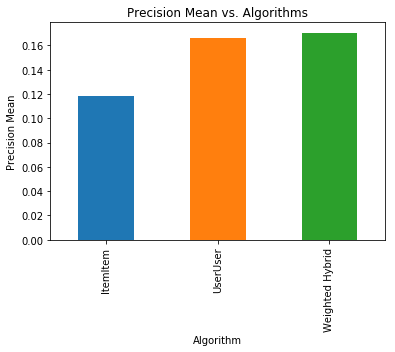

In [24]:
ax = precision_mean.plot.bar()
ax.set_ylabel("Precision Mean")
ax.set_title("Precision Mean vs. Algorithms")
plt.show()

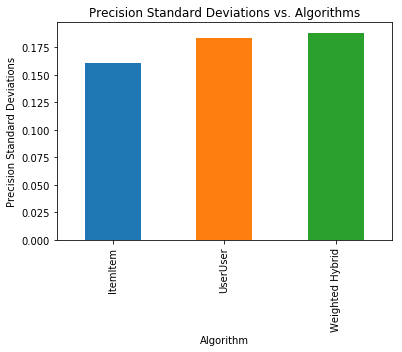

In [25]:
ax = precision_std.plot.bar()
ax.set_ylabel("Precision Standard Deviations")
ax.set_title("Precision Standard Deviations vs. Algorithms")
plt.show()

### Bar plot of recall
As above

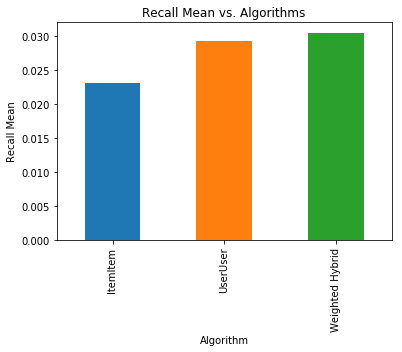

In [26]:
ax = recall_mean.plot.bar()
ax.set_ylabel("Recall Mean")
ax.set_title("Recall Mean vs. Algorithms")
plt.show()

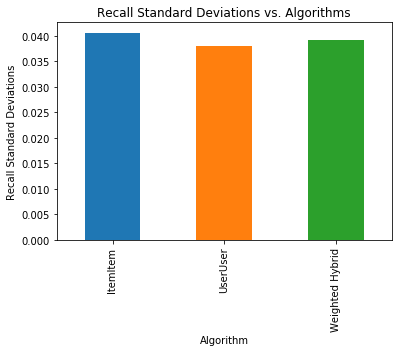

In [27]:
ax = recall_std.plot.bar()
ax.set_ylabel("Recall Standard Deviations")
ax.set_title("Recall Standard Deviations vs. Algorithms")
plt.show()

### (Optional) Scatter plot of recall / precision
See example

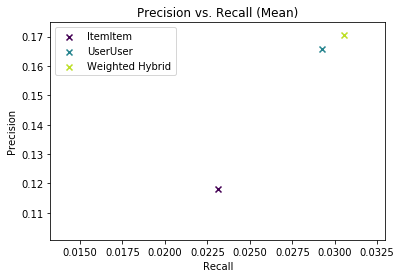

In [28]:
# ax = precision_mean.plot.scatter(x='Algorithm', y='Precision Mean', c='DarkBlue')
from matplotlib import cm
from matplotlib import colors
fig, ax = plt.subplots()

df = pd.DataFrame({'Precision':precision_mean.values, 'Recall':recall_mean.values, 'Algorithm':['ItemItem', 'UserUser', 'Weighted Hybrid']})

colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(df['Algorithm']))]

for i,c in enumerate(colorlist):
    x = df['Recall'][i]
    y = df['Precision'][i]
    l = df['Algorithm'][i]
    ax.scatter(x, y, label=l, marker='x', c=c)
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision vs. Recall (Mean)')
plt.show()

## INFO 5871 only
In this section, you will attempt to use linear regression to learn optimal weights for the hybrid. The process is as follows:

- Extract one of the five partitions from the cross-validation iterator. This will be used to learn the weights and then not used for evaluation.
- Train the user-based and item-based algorithms on this partition.
- Use `batch.predict` to compute predictions over the test data.
- Construct a linear regression (`sklearn.linear_model` with `fit_intercept` equal to `False`) with the real test set ratings as the predicted variable and the predictions of the two algorithms as the independent variables.
- Use the coefficients learned by this process to construct a new hybrid.
- Use the remaining four folds of the data to do an evaluation, collecting both prediction values and recommendation lists.
- Following the same methodology as above, produce plots (with error bars) of RMSE and nDCG.
- Don't forget to answer the question at the end.

In [29]:
from sklearn.linear_model import LinearRegression

### Get one partition for training weights

In [30]:
np.random.seed(20190302)
partitions = list(xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)))
train, test = partitions[0]

In [31]:
reg_user = UserUserFallback(20, min_nbrs=5)
reg_item = ItemItemFallback(20, min_nbrs=5)

### Train and predict components on first partition

In [32]:
# UserUser
fittable = my_clone(reg_user)
fittable.fit(train) 
pred_user = batch.predict(fittable, test)

In [33]:
# ItemItem
fittable = my_clone(reg_item)
fittable.fit(train) 
pred_item = batch.predict(fittable, test)

In [34]:
pred_user.head()

,user,item,rating,prediction
82397,359,4144,3.0,4.143361
82312,359,3061,4.5,3.886495
82010,359,800,4.0,4.028620
82589,359,8985,4.0,2.448638
82659,359,48043,4.0,3.896176


In [35]:
pred_item.head()

,user,item,rating,prediction
82397,359,4144,3.0,3.849022
82312,359,3061,4.5,3.931315
82010,359,800,4.0,4.325859
82589,359,8985,4.0,2.810591
82659,359,48043,4.0,3.680990


### Create numpy arrays of predictions and actual ratings

In [36]:
user_array = pred_user.prediction.values #take column in numpy
item_array = pred_item.prediction.values  

In [37]:
predictions = np.stack((user_array,item_array), axis = 1)
actuals = test.rating.values

### Run linear regression
fit_intercept = False

In [38]:
linear_regression = LinearRegression(fit_intercept=False).fit(predictions, actuals)

### Print regression coefficients

In [39]:
linear_regression.coef_

array([0.16141287, 0.82814307])

### Create hybrid with regression coefficients as weights

In [53]:
reg_weighted_hybrid = WeightedHybrid([reg_user, reg_item], linear_regression.coef_)

### Run experiment
Do both prediction and recommendation experiments

In [54]:
np.random.seed(20190303)

all_preds2 = []
fold = 0
all_recs2 = []
test_data2 = []

algorithm_type = [(reg_user,'UserUser'), (reg_item,'ItemItem'), (reg_weighted_hybrid,'Weighted Hybrid')]

for train, test in partitions[1:]:
    test_data2.append(test)
    for algo in algorithm_type:
        all_preds2.append(eval_preds(algo[1], fold, algo[0], train, test))
        all_recs2.append(eval_recs(algo[1], fold, algo[0], train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3


### Compute RMSE results
Average over the four folds

In [55]:
all_preds2 = pd.concat(all_preds2, ignore_index=True)
all_recs2 = pd.concat(all_recs2, ignore_index=True)
test_data2 = pd.concat(test_data2, ignore_index=True)

In [64]:
rmse_per_fold = all_preds2.groupby(['Algorithm', 'Fold']).apply(lambda df: rmse(df.prediction, df.rating))
means = rmse_per_fold.groupby('Algorithm').mean()
stds = rmse_per_fold.groupby('Algorithm').std()
print("RMSE Mean: \n",means)
print()
print("RMSE Standard deviation: \n", stds)


RMSE Mean: 
 Algorithm
ItemItem           0.757763
UserUser           0.788136
Weighted Hybrid    0.756076
dtype: float64

RMSE Standard deviation: 
 Algorithm
ItemItem           0.019112
UserUser           0.018543
Weighted Hybrid    0.019099
dtype: float64


### Display RMSE bar plot with error bars

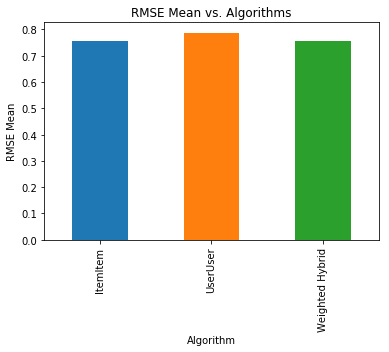

In [57]:
ax = means.plot.bar()
ax.set_ylabel("RMSE Mean")
ax.set_title("RMSE Mean vs. Algorithms")
plt.show()

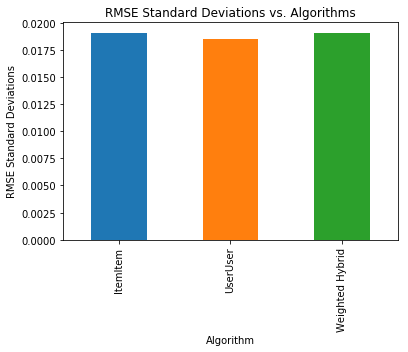

In [58]:
ax = stds.plot.bar()
ax.set_ylabel("RMSE Standard Deviations")
ax.set_title("RMSE Standard Deviations vs. Algorithms")
plt.show()

### Compute nDCG
Average the users over each fold, then average the folds

In [59]:
rla2 = topn.RecListAnalysis()
rla2.add_metric(topn.ndcg)

byuser_results2 = all_recs2.groupby(['Algorithm', 'Fold']).apply(lambda df: rla2.compute(df, test_data2))
byuser_results2.head()

ndcg
Algorithm Fold user Algorithm Fold          
ItemItem  0    1738 ItemItem  0     0.042091
               1935 ItemItem  0     0.000000
               2847 ItemItem  0     0.126752
               2988 ItemItem  0     0.059240
               3665 ItemItem  0     0.094552

In [60]:
ndcg_mean = byuser_results2.groupby('Algorithm')['ndcg'].mean()
ndcg_mean.head()

Algorithm
ItemItem           0.047627
UserUser           0.067467
Weighted Hybrid    0.056393
Name: ndcg, dtype: float64

In [61]:
ndcg_std = byuser_results2.groupby('Algorithm')['ndcg'].std()
ndcg_std.head()

Algorithm
ItemItem           0.063558
UserUser           0.069732
Weighted Hybrid    0.068217
Name: ndcg, dtype: float64

### Display nDCG bar plot with error bars

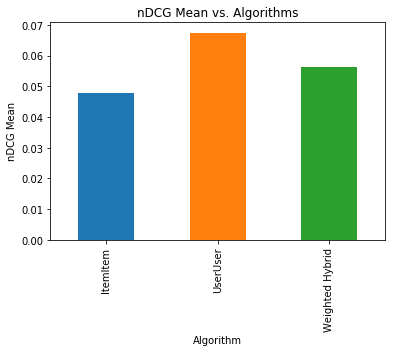

In [62]:
ax = ndcg_mean.plot.bar()
ax.set_ylabel("nDCG Mean")
ax.set_title("nDCG Mean vs. Algorithms")
plt.show()

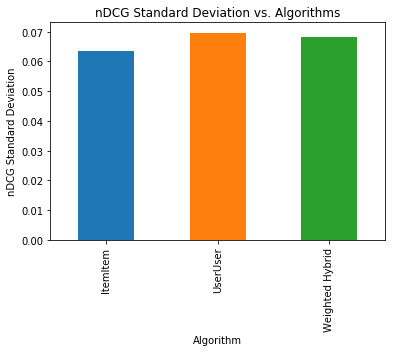

In [63]:
ax = ndcg_std.plot.bar()
ax.set_ylabel("nDCG Standard Deviation")
ax.set_title("nDCG Standard Deviation vs. Algorithms")
plt.show()

### Question:
The optimization procedure produces a hybrid that has a lower RMSE than either component. But that hybrid does not have the highest nDCG. Why did this happen? What must be true about the distribution of errors such that this hybrid does not produce the best ranking?

__Solution__ . 
>__nDCG__ measures the performance of a recommendation system based on the graded relevance of the recommended entities. Closer the value of nDCG to 1, more correlated are the entitites.

>__RMSE__ is generally used for evaluating accuracy of predicted ratings. RMSE also depends on the __total number of ratings__.

>The reason for low RMSE and low nDCG could be   
- The weight for ItemItem algorithm is much greater than the weight for UserUser. Thus, predictions for hybrid will be closer to the predictions for ItemItem. Since, RMSE of ItemItem is low, RMSE for hybrid may tend to be low too. 
- Training is focused on items with the most ratings which will achieve a good fit for such items. So, more the data(ratings) for each item/user better will be the training and hence the fit. But items/users with few ratings don’t mean much in terms of their impact on the loss(RMSE). As a result, predictions for these items/users will be off. Some will get scores much higher, some will get much lower than actual. Thus, it's possible that the RMSE is low even though the predictions are off since those items/users have less ratings. And since predictions are off, recommendations will be off, hence, ranking will be incorrect which explains low nDCG for hybrid.